In [25]:
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
from functions import *

folder_path = "test_cases"

Case 1 {0: 437536, 255: 418089} (925, 925)
Estimated Rotation Angle: 8.000007629394531
Case 2 {0: 389102, 255: 394717} (981, 799)
Case 3 {0: 433664, 255: 421961} (925, 925)
Case 4 {0: 408324, 255: 449152} (926, 926)
Case 5 {0: 481743, 255: 494352} (981, 995)
Case 6 {0: 255111, 255: 529156} (859, 913)
Case 7 {0: 375303, 255: 480322} (925, 925)
Case 8 {0: 395494, 255: 461982} (926, 926)
Case 9 {0: 419673, 255: 440583} (928, 927)
Case 10 {0: 401472, 255: 431841} (897, 929)
Case 11 {0: 424069, 255: 438971} (930, 928)
Case 12 {0: 464694, 255: 421722} (944, 939)
Case 13 {0: 376013, 255: 480537} (926, 925)
Estimated Rotation Angle: 21.00000762939453
Case 14 {0: 7447, 255: 9065} (128, 129)
Case 15 {0: 19620, 255: 21792} (203, 204)
Case 16 {0: 476006, 255: 441758} (958, 958)
Case 17 {0: 406114, 255: 449511} (925, 925)
Case 18 {0: 453024, 255: 402601} (925, 925)


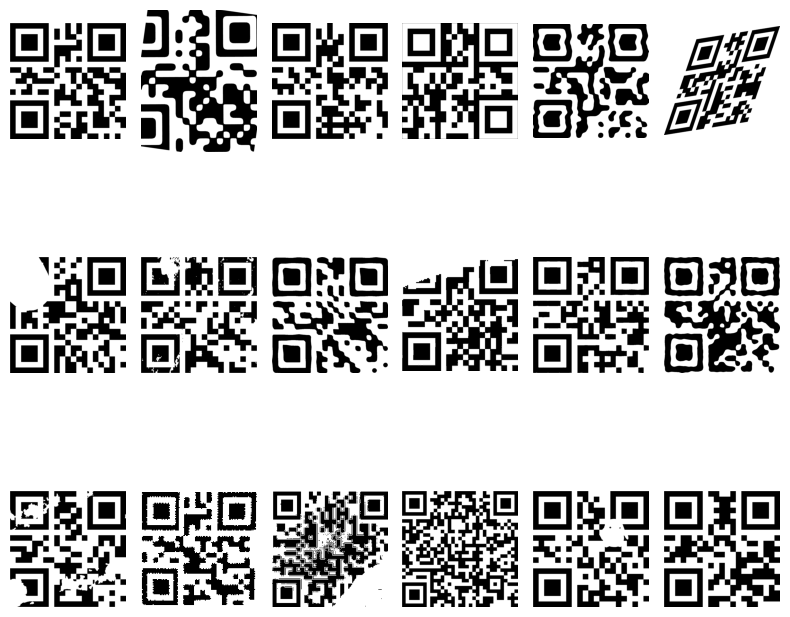

In [26]:
fig, axes = plt.subplots(3, 6, figsize=(8, 8))
for i, filename in enumerate(os.listdir(folder_path)):
    if i >= 18:
        break
    
    
    image_path = os.path.join(folder_path, filename)
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    image_new = np.uint8(fix_sin_wave(image))

    # Initial Thresholding and Histogram Equalization
    _, image_new = cv2.threshold(image_new, 95, 192, cv2.THRESH_BINARY)
    image_new = cv2.equalizeHist(np.uint8(image_new))

    # If new image is corrupted (all black or all white), keep original for now
    hist_values = unique_pixel_values(image_new)
    if len(hist_values) == 1:
        image_new = image


    # By observation, 99% of QR images thresholding will have more white pixels than black pixels
    # So, if black pixels are more than white pixels, invert image
    hist_values = unique_pixel_values(image_new)

    # Needs rework (Broken)
    image_new = fix_inverted(image_new, hist_values)


    # Checking for extreme low/high brightess

    hist_values = unique_pixel_values(image_new)

    # Low Brightness fix
    image_new = fix_low_brightness(image_new, hist_values)
    
    # High Brightness fix
    image_new = fix_high_brightness(image_new, hist_values)


    # After all above preprocessing, if an image still doesn't have any black or white pixel values, it is most probably a low contrast image
    # Preprocessing with average of key values as threshold to fix low contrast images
    hist_values = unique_pixel_values(image_new)
    image_new = fix_low_contrast(image_new, hist_values)


    # After all previous preprocessing all QR codes quiet zones should be pure white pixels only
    # If the first 5x5 window in image still contains more than 1 pixel value, then it must contain salt & pepper noise
    small_corner = unique_pixel_values(image_new[0:5][0:5])
    if len(small_corner) > 1:
        image_new = fix_salt_pepper(image)


    # DANGER ZONE
    ################################################################

    # Detect all three locator boxes to detect QR code frame
    locator_boxes = detect_locator_boxes(image_new)

    if locator_boxes:
        # Expand to encompass the entire QR code
        expanded_box = expand_to_qr_code(image_new, locator_boxes)

        # This function simulates a zoom effect to be able to frame smaller qr codes more accurately
        image_new = crop_to_bounding_box_margin(image_new, expanded_box, margin=50)

        # This function fixes tilt in images using Hough Lines, it works only for tilt angles less than 45
        image_new = fix_tilt(image_new)

        # Detect locator boxes again after zooming
        locator_boxes = detect_locator_boxes(image_new)

        # Get QR frame coordinates
        expanded_box = expand_to_qr_code(image_new, locator_boxes)

        # Draw QR frame
        x, y, w, h = expanded_box
        # cv2.rectangle(image_new, (x, y), (x + w, y + h), (0, 0, 0), 3)


        # Crop image to locator frame size
        image_new = crop_to_bounding_box(image_new, expanded_box)


    # FIX 6 HERE
    # image_new = fix_locator_box_skew(image_new)

    # rotate images that has clear 3 locator boxes (to be moved down)
    image_new = rotate_image(image_new)


    # Resizing for decoding
    #########################################

    # if image_new.shape > (924, 924):
    #     image_new = cv2.resize(image_new, (924, 924), interpolation=cv2.INTER_LINEAR)
    #     image_new = replace_with_median(image_new, 924)
    # elif image_new.shape > (672, 672):
    #     image_new = cv2.resize(image_new, (672, 672), interpolation=cv2.INTER_LINEAR)
    #     image_new = replace_with_median(image_new, 672)
    # elif image_new.shape > (420, 420):
    #     image_new = cv2.resize(image_new, (420, 420), interpolation=cv2.INTER_LINEAR)
    #     image_new = replace_with_median(image_new, 420)
    # else:
    #     image_new = cv2.resize(image_new, (168, 168), interpolation=cv2.INTER_LINEAR)
    #     image_new = replace_with_median(image_new, 168)



    # Apply Final thresholding to remove any noise pixels
    _, image_new = cv2.threshold(image_new, 64, 255, cv2.THRESH_BINARY)

    # Plot the image in the corresponding subplot
    row = i // 6
    col = i % 6
    axes[row, col].axis('off')
    axes[row, col].imshow(image_new, cmap='gray')

    hist_values = unique_pixel_values(image_new)
    print(f"Case {i+1}", hist_values, image_new.shape)

plt.tight_layout()
plt.show()